# Traffic Volume Predictor

## Step 1: Importing Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Step 2: Loading Dataset

In [3]:
# Reading the Training Data
traffic_data = pd.read_csv("/kaggle/input/123ofai-predict-the-traffic-volume/train_set_dirty.csv")

# Reading the external holiday data
test_data = pd.read_csv("/kaggle/input/123ofai-predict-the-traffic-volume/test_set_nogt.csv")

# Reading the external holiday data
holiday_data=pd.read_csv("/kaggle/input/holiday-list/holiday_list.csv")

## Step 3: EDA (Exploratory Data Analysis)

In [4]:
traffic_data.head()

,traffic_volume,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1493.0,NaN,287.15,0.00,0.0,90.0,Mist,NaN,18-09-2017 22:00
1,NaN,NaN,282.25,0.00,0.0,90.0,Clouds,overcast clouds,23-05-2013 11:00
2,NaN,NaN,NaN,0.00,0.0,90.0,Drizzle,drizzle,04-06-2016 01:00
3,5626.0,NaN,252.08,0.00,0.0,20.0,Haze,haze,04-01-2017 08:00
4,5357.0,NaN,291.25,1.02,0.0,NaN,Rain,moderate rain,13-06-2013 13:00


In [5]:
traffic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38563 entries, 0 to 38562
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       34748 non-null  float64
 1   holiday              42 non-null     object 
 2   temp                 34754 non-null  float64
 3   rain_1h              34860 non-null  float64
 4   snow_1h              34733 non-null  float64
 5   clouds_all           34659 non-null  float64
 6   weather_main         34654 non-null  object 
 7   weather_description  34751 non-null  object 
 8   date_time            34683 non-null  object 
dtypes: float64(5), object(4)
memory usage: 2.6+ MB


In [6]:
traffic_data.describe()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all
count,34748.000000,34754.000000,34860.000000,34733.000000,34659.000000
mean,3254.207753,281.164396,0.414656,0.000242,49.472605
std,1987.318504,13.534323,52.665546,0.008662,39.013199
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1187.000000,272.150000,0.000000,0.000000,1.000000
50%,3370.500000,282.420000,0.000000,0.000000,64.000000
75%,4931.000000,291.770000,0.000000,0.000000,90.000000
max,7280.000000,308.430000,9831.300000,0.510000,100.000000


In [7]:
traffic_data.describe(include='object')

,holiday,weather_main,weather_description,date_time
count,42,34654,34751,34683
unique,11,11,38,30414
top,New Years Day,Clouds,sky is clear,05-11-2017 01:00
freq,5,10938,8335,5


### Observation 1: Duplicates at *date_time* level

After looking at data we can clearly see that data is reacorded at date_time in hourly manner in a day. Ideally we should have a single record for each date_time.

In [8]:
# show duplicates at date_time
traffic_data['date_time'].value_counts()[lambda x:x>1]

date_time
05-11-2017 01:00    5
14-04-2018 09:00    5
19-05-2013 08:00    5
21-05-2013 23:00    5
20-03-2018 14:00    5
                   ..
18-05-2017 06:00    2
28-03-2016 02:00    2
11-08-2017 03:00    2
09-06-2018 16:00    2
12-10-2017 08:00    2
Name: count, Length: 3431, dtype: int64

### Observation 2: *holiday* data is not mapped correctly

In 2017, 'New Years Day' is not mapped correctly

In [13]:
required_dates=['01-01-2013 00:00','01-01-2014 00:00','01-01-2016 00:00','01-01-2017 00:00','01-01-2018 00:00']

traffic_data.loc[traffic_data['date_time'].isin(required_dates),['date_time','holiday']]

,date_time,holiday
974,01-01-2018 00:00,New Years Day
30273,01-01-2016 00:00,New Years Day
30692,01-01-2016 00:00,New Years Day
35363,01-01-2017 00:00,NaN
35754,01-01-2013 00:00,New Years Day


Also holiday data is mapped to only 00:00 hrs

In [16]:
required_dates=['01-01-2013 00:00','01-01-2013 02:00','01-01-2013 04:00','01-01-2013 05:00','01-01-2013 08:00','01-01-2013 09:00','01-01-2013 10:00','01-01-2013 12:00','01-01-2013 14:00','01-01-2013 15:00','01-01-2013 16:00','01-01-2013 18:00','01-01-2013 19:00','01-01-2013 20:00','01-01-2013 22:00','01-01-2013 23:00']
traffic_data.loc[traffic_data['date_time'].isin(required_dates),['date_time','holiday']].sort_values(by='date_time')

,date_time,holiday
35754,01-01-2013 00:00,New Years Day
32864,01-01-2013 02:00,NaN
37345,01-01-2013 04:00,NaN
27837,01-01-2013 05:00,NaN
30753,01-01-2013 08:00,NaN
16985,01-01-2013 09:00,NaN
16473,01-01-2013 10:00,NaN
36501,01-01-2013 12:00,NaN
30922,01-01-2013 14:00,NaN
6009,01-01-2013 15:00,NaN


Given that Independence Day on July 4th is a distinctly American holiday, its presence in the data strongly suggests that the dataset originates from the United States

In [19]:
traffic_data.loc[traffic_data['holiday']=='Independence Day',['date_time','holiday']]

,date_time,holiday
12413,NaN,Independence Day
16973,04-07-2013 00:00,Independence Day


Not all holidays are mapped like Easter day, New Years eve, Juneteenth

In [18]:
traffic_data['holiday'].value_counts()

holiday
New Years Day                5
Columbus Day                 5
Christmas Day                5
Veterans Day                 5
Memorial Day                 4
Martin Luther King Jr Day    4
Thanksgiving Day             4
Labor Day                    3
State Fair                   3
Independence Day             2
Washingtons Birthday         2
Name: count, dtype: int64

### Observation 3: Data has cyclical nature based on hours

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


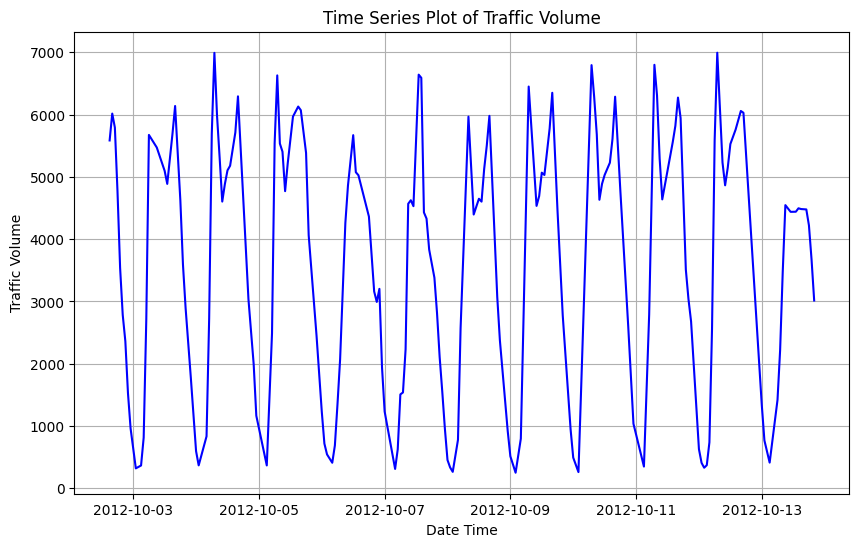

In [31]:
temp=traffic_data
temp['date_time']=pd.to_datetime(temp['date_time'],format='%d-%m-%Y %H:%M')

temp=temp.sort_values(by='date_time')
temp=temp[1:200]

# Plot the time series of traffic volume using Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=temp, x='date_time', y='traffic_volume', color='blue')
plt.title('Time Series Plot of Traffic Volume')
plt.xlabel('Date Time')
plt.ylabel('Traffic Volume')
plt.grid(True)
plt.show()

### Observation 4: *weather_main* and *weather_description* can derive from each other

1. Text need to be converted into singular format like lowercase/uppercase
2. Since *weather_description* categories are dependent on *weather_main*, we can easily derive *weather_main* from *weather_description*
3. For vice-versa, we can impute most frequent *weather_description* based on *weather_main* 

In [45]:
temp=traffic_data[['weather_main','weather_description']].sort_values(by='weather_main')
temp.value_counts().sort_index()

weather_main  weather_description                
Clear         Sky is Clear                           1114
              sky is clear                           7491
Clouds        broken clouds                          3003
              few clouds                             1298
              overcast clouds                        3333
              scattered clouds                       2239
Drizzle       drizzle                                 421
              heavy intensity drizzle                  48
              light intensity drizzle                 673
              shower drizzle                            2
Fog           fog                                     590
Haze          haze                                    900
Mist          mist                                   3877
Rain          freezing rain                             1
              heavy intensity rain                    297
              light intensity shower rain               9
              light ra

## Step 5: Data Cleansing (DC)

### DC Step 1: Format *date_time*

In [28]:
traffic_data['date_time']=pd.to_datetime(traffic_data['date_time'],format='%d-%m-%Y %H:%M')

### DC Step 2: Remove duplicates based on *date_time*

In [29]:
# Sorting data as per date_time
traffic_data.sort_values(by='date_time', inplace=True)

# Remove duplicates based on 'date_time'
traffic_data = traffic_data.drop_duplicates(subset='date_time', keep='first')

# Reset index if needed
traffic_data.reset_index(drop=True, inplace=True)

# info
traffic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30415 entries, 0 to 30414
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   traffic_volume       27443 non-null  float64       
 1   holiday              32 non-null     object        
 2   temp                 27411 non-null  float64       
 3   rain_1h              27476 non-null  float64       
 4   snow_1h              27372 non-null  float64       
 5   clouds_all           27372 non-null  float64       
 6   weather_main         27330 non-null  object        
 7   weather_description  27383 non-null  object        
 8   date_time            30414 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5), object(3)
memory usage: 2.1+ MB


### DC Step 3: Map correct *holiday* data

Reference : [US holiday data (2004-2021)](https://www.kaggle.com/datasets/donnetew/us-holiday-dates-2004-2021/)

Manual corrections in external data:

1. Corrected few character issue
2. Changed 4th July to Independence day
3. Added State Fair data manually (last/second last Thursday of Aug)
4. Made Easter Easter Day and Western Easter Day as Easter Day
5. Removed Duplicates


In [30]:
# map correct holiday data
def add_holiday_data(df, h_data):
    # Convert 'Date' column to datetime format
    h_data['Date'] = pd.to_datetime(h_data['Date'], format='%Y-%m-%d')
    
    # Convert 'date_time' to date
    df['date'] = pd.to_datetime(df['date_time'].dt.date)
    
    # Drop old 'holiday' column
    df.drop(['holiday'], axis=1, inplace=True)
    
    # Merge new holiday data to df
    df = pd.merge(df, h_data, left_on='date', right_on='Date', how='left')
    
    # Replace NaN with None in 'Holiday' column
    df['Holiday'] = df['Holiday'].replace(np.nan, None)
    
    # Drop intermediate column 'Date'
    df.drop(columns=['Date'], inplace=True)
    
    # Rename 'Holiday' column to 'holiday'
    df.rename(columns={'Holiday': 'holiday'}, inplace=True)
    
    return df

# Mapping holiday data
traffic_data=add_holiday_data(traffic_data,holiday_data)

# Describe data
traffic_data.describe(include=object)

,weather_main,weather_description,holiday
count,27330,27383,1625
unique,11,36,18
top,Clouds,sky is clear,Labor Day Weekend
freq,9858,7482,139


### DC Step 4: Impute *temp*, *rain_1h*, *clouds_all* data

In [31]:
# taking average of forward and backward data
def handle_missing_data(df, column_name):
    # Forward fill and backward fill
    df[column_name+'_ffill'] = df[column_name].ffill()
    df[column_name+'_bfill'] = df[column_name].bfill()
    
    # Impute mean
    df[column_name] = df[column_name].fillna((df[column_name+'_ffill'] + df[column_name+'_bfill']) / 2)
    
    # Drop intermediate columns
    df.drop(columns=[column_name+'_ffill', column_name+'_bfill'], inplace=True)
    
    return df

# Sort the data by 'date_time'
traffic_data.sort_values(by='date_time', inplace=True)

# Apply the function for 'temp'
traffic_data=handle_missing_data(traffic_data, 'temp')

# Apply the function for 'rain_1h'
traffic_data=handle_missing_data(traffic_data, 'rain_1h')

# Apply the function for 'snow_1h'
traffic_data=handle_missing_data(traffic_data, 'snow_1h')

# Apply the function for 'clouds_all'
traffic_data=handle_missing_data(traffic_data, 'clouds_all')

# top 100 rows
traffic_data.head(10)

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,date,holiday
0,5545.0,288.28,0.0,0.0,40.0,Clouds,scattered clouds,2012-10-02 09:00:00,2012-10-02,None
1,NaN,289.36,0.0,0.0,20.5,Clouds,broken clouds,2012-10-02 10:00:00,2012-10-02,None
2,5584.0,293.17,0.0,0.0,1.0,Clear,sky is clear,2012-10-02 15:00:00,2012-10-02,None
3,6015.0,293.86,0.0,0.0,1.0,Clear,NaN,2012-10-02 16:00:00,2012-10-02,None
4,5791.0,294.14,0.0,0.0,20.0,Clouds,few clouds,2012-10-02 17:00:00,2012-10-02,None
5,4770.0,293.10,0.0,0.0,20.0,Clouds,few clouds,2012-10-02 18:00:00,2012-10-02,None
6,3539.0,290.97,0.0,0.0,20.0,Clouds,few clouds,2012-10-02 19:00:00,2012-10-02,None
7,2784.0,289.38,0.0,0.0,10.5,Clear,NaN,2012-10-02 20:00:00,2012-10-02,None
8,2361.0,288.61,0.0,0.0,1.0,Clear,sky is clear,2012-10-02 21:00:00,2012-10-02,None
9,1529.0,287.16,0.0,0.0,1.0,Clear,sky is clear,2012-10-02 22:00:00,2012-10-02,None


### DC Step 5: Impute *weather_main* using *weather_description*

In [32]:
# lower text of weather_main and weather_description
traffic_data['weather_main'] = traffic_data['weather_main'].str.lower()
traffic_data['weather_description'] = traffic_data['weather_description'].str.lower()

# list of unique weather_main and weather_description
unique_combo_weather = traffic_data[traffic_data['weather_main'].notna() & traffic_data['weather_description'].notna()][['weather_main', 'weather_description']].drop_duplicates()
unique_combo_weather=unique_combo_weather.rename(columns={'weather_main':'weather_main_unique','weather_description':'weather_description_unique'})

# mapping weather_main_unique where weather_main is blank
traffic_data=traffic_data.replace('None',None)
traffic_data=pd.merge(traffic_data,unique_combo_weather,left_on='weather_description',right_on='weather_description_unique', how='left')
traffic_data['weather_main']=traffic_data['weather_main'].fillna(traffic_data['weather_main_unique'])

# Removing intermediate column
traffic_data.drop(columns=['weather_description_unique','weather_main_unique'], inplace=True)

traffic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30415 entries, 0 to 30414
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   traffic_volume       27443 non-null  float64       
 1   temp                 30415 non-null  float64       
 2   rain_1h              30415 non-null  float64       
 3   snow_1h              30415 non-null  float64       
 4   clouds_all           30415 non-null  float64       
 5   weather_main         30085 non-null  object        
 6   weather_description  27383 non-null  object        
 7   date_time            30414 non-null  datetime64[ns]
 8   date                 30414 non-null  datetime64[ns]
 9   holiday              1625 non-null   object        
dtypes: datetime64[ns](2), float64(5), object(3)
memory usage: 2.3+ MB


## DC Step 6: Impute *weather_description* using *weather_main*

In [33]:
# imputing weather_description with most frequent category of the category  
traffic_data['weather_description'] = traffic_data.groupby('weather_main')['weather_description'].transform(lambda x: x.fillna(x.mode().iloc[0]))

# top 20 rows
traffic_data.head(20)

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,date,holiday
0,5545.0,288.28,0.0,0.0,40.0,clouds,scattered clouds,2012-10-02 09:00:00,2012-10-02,None
1,NaN,289.36,0.0,0.0,20.5,clouds,broken clouds,2012-10-02 10:00:00,2012-10-02,None
2,5584.0,293.17,0.0,0.0,1.0,clear,sky is clear,2012-10-02 15:00:00,2012-10-02,None
3,6015.0,293.86,0.0,0.0,1.0,clear,sky is clear,2012-10-02 16:00:00,2012-10-02,None
4,5791.0,294.14,0.0,0.0,20.0,clouds,few clouds,2012-10-02 17:00:00,2012-10-02,None
5,4770.0,293.10,0.0,0.0,20.0,clouds,few clouds,2012-10-02 18:00:00,2012-10-02,None
6,3539.0,290.97,0.0,0.0,20.0,clouds,few clouds,2012-10-02 19:00:00,2012-10-02,None
7,2784.0,289.38,0.0,0.0,10.5,clear,sky is clear,2012-10-02 20:00:00,2012-10-02,None
8,2361.0,288.61,0.0,0.0,1.0,clear,sky is clear,2012-10-02 21:00:00,2012-10-02,None
9,1529.0,287.16,0.0,0.0,1.0,clear,sky is clear,2012-10-02 22:00:00,2012-10-02,None


### DC Step 7: Removing null rows

In [34]:
# info
print("#########################")
print("Before removing rows")
print("#########################")
traffic_data.info()

# removing rows where traffic_volume and date_time is null
traffic_data=traffic_data[traffic_data['traffic_volume'].notna() & traffic_data['date_time'].notna()]

# info
print("#########################")
print("After removing rows")
print("#########################")
traffic_data.info()

#########################
Before removing rows
#########################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30415 entries, 0 to 30414
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   traffic_volume       27443 non-null  float64       
 1   temp                 30415 non-null  float64       
 2   rain_1h              30415 non-null  float64       
 3   snow_1h              30415 non-null  float64       
 4   clouds_all           30415 non-null  float64       
 5   weather_main         30085 non-null  object        
 6   weather_description  30085 non-null  object        
 7   date_time            30414 non-null  datetime64[ns]
 8   date                 30414 non-null  datetime64[ns]
 9   holiday              1625 non-null   object        
dtypes: datetime64[ns](2), float64(5), object(3)
memory usage: 2.3+ MB
#########################
After removing rows
#################

### DC Step 8: Outlier Treatment

In [35]:
# # loading required packages
# from scipy.stats.mstats import winsorize

# # Convert numerical columns to numeric data type if needed
# numerical_columns = ['temp', 'rain_1h', 'snow_1h', 'clouds_all']
# traffic_data[numerical_columns] = traffic_data[numerical_columns].apply(pd.to_numeric, errors='coerce')
 
# # capping extream 5% and -5% data
# for col in numerical_columns:
#     traffic_data[col] = winsorize(traffic_data[col], limits=[0.05, 0.05])

In [36]:
print('###############')
print('After Data Cleaning')
print('###############')

traffic_data.describe()

###############
After Data Cleaning
###############


,traffic_volume,temp,rain_1h,snow_1h,clouds_all,date_time,date
count,27442.000000,27442.000000,27442.000000,27442.000000,27442.000000,27442,27442
mean,3278.861781,281.245336,0.089718,0.000117,45.632315,2015-12-26 20:39:45.088550144,2015-12-26 09:09:40.103490816
min,0.000000,0.000000,0.000000,0.000000,0.000000,2012-10-02 09:00:00,2012-10-02 00:00:00
25%,1233.000000,271.870000,0.000000,0.000000,1.000000,2014-02-01 08:30:00,2014-02-01 00:00:00
50%,3400.000000,282.764000,0.000000,0.000000,40.000000,2016-06-06 21:30:00,2016-06-06 00:00:00
75%,4942.750000,292.150000,0.000000,0.000000,90.000000,2017-08-05 04:00:00,2017-08-05 00:00:00
max,7280.000000,308.430000,55.630000,0.510000,100.000000,2018-09-30 23:00:00,2018-09-30 00:00:00
std,1986.869363,13.704942,0.873248,0.005532,38.468733,NaN,NaN


In [37]:
traffic_data.describe(include='object')

,weather_main,weather_description,holiday
count,27152,27152,1468
unique,11,34,18
top,clouds,sky is clear,Labor Day Weekend
freq,9804,8489,123


## Step 6: Feature Engineering (FE)

### FE Step 1: Creating new variables based on *date_time*

In [38]:
# Create additional columns based on date_time like day, week of the day, month, year
def datetime_columns(df):
    df["date_time"]=pd.to_datetime(df["date_time"])
    
    #Creating additional variables from date_time
    df["hour"] = df["date_time"].dt.hour
    df["day"] = df["date_time"].dt.day
    df["weekday"] = df["date_time"].dt.weekday
    df["month"] = df["date_time"].dt.month
    df["year"] = df["date_time"].dt.year
    
    # Create flag for identifying weekday and weekend 
    df["weekday_categorical"] = df["weekday"].map(lambda x: 1 if x >= 0 & x <= 4 else 0 )
    
    # Create cyclical features for hour of the day
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    return df

traffic_data=datetime_columns(traffic_data)
traffic_data.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,date,holiday,hour,day,weekday,month,year,weekday_categorical,hour_sin,hour_cos
0,5545.0,288.28,0.0,0.0,40.0,clouds,scattered clouds,2012-10-02 09:00:00,2012-10-02,None,9,2,1,10,2012,1,0.707107,-7.071068e-01
2,5584.0,293.17,0.0,0.0,1.0,clear,sky is clear,2012-10-02 15:00:00,2012-10-02,None,15,2,1,10,2012,1,-0.707107,-7.071068e-01
3,6015.0,293.86,0.0,0.0,1.0,clear,sky is clear,2012-10-02 16:00:00,2012-10-02,None,16,2,1,10,2012,1,-0.866025,-5.000000e-01
4,5791.0,294.14,0.0,0.0,20.0,clouds,few clouds,2012-10-02 17:00:00,2012-10-02,None,17,2,1,10,2012,1,-0.965926,-2.588190e-01
5,4770.0,293.10,0.0,0.0,20.0,clouds,few clouds,2012-10-02 18:00:00,2012-10-02,None,18,2,1,10,2012,1,-1.000000,-1.836970e-16


### FE Step 2: Creating ordinal variable based of holiday category



In [39]:
def holiday_columns(df):
    # creating categorical variable based on observation
    df['holiday_categorical']=0
    df.loc[df['holiday'].isin(['Christmas Day']),['holiday_categorical']]=2
    df.loc[df['holiday'].isin(["Christmas Eve","Independence Day","Labor Day","Martin Luther King, Jr. Day","Memorial Day","New Year's Day","Thanksgiving Day"]),['holiday_categorical']]=3
    df.loc[df['holiday'].isin(["Columbus Day","Juneteenth","Labor Day Weekend","New Year's Eve","State Fair","Thanksgiving Eve","Valentine's Day","Veterans Day","Washington's Birthday","Easter"]),['holiday_categorical']]=4
    
    return df

traffic_data=holiday_columns(traffic_data)
traffic_data.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,date,holiday,hour,day,weekday,month,year,weekday_categorical,hour_sin,hour_cos,holiday_categorical
0,5545.0,288.28,0.0,0.0,40.0,clouds,scattered clouds,2012-10-02 09:00:00,2012-10-02,None,9,2,1,10,2012,1,0.707107,-7.071068e-01,0
2,5584.0,293.17,0.0,0.0,1.0,clear,sky is clear,2012-10-02 15:00:00,2012-10-02,None,15,2,1,10,2012,1,-0.707107,-7.071068e-01,0
3,6015.0,293.86,0.0,0.0,1.0,clear,sky is clear,2012-10-02 16:00:00,2012-10-02,None,16,2,1,10,2012,1,-0.866025,-5.000000e-01,0
4,5791.0,294.14,0.0,0.0,20.0,clouds,few clouds,2012-10-02 17:00:00,2012-10-02,None,17,2,1,10,2012,1,-0.965926,-2.588190e-01,0
5,4770.0,293.10,0.0,0.0,20.0,clouds,few clouds,2012-10-02 18:00:00,2012-10-02,None,18,2,1,10,2012,1,-1.000000,-1.836970e-16,0



### FE Step 3: one hot enconding *weather_main* and *weather_description* and aggregating columns based on *weather_main*

In [40]:
def aggregating_weather_main(df,col_list,weights,col):
    present_columns = [col for col in col_list if col in df.columns]

    if present_columns:
        col_weights = [weights[i] for i, col in enumerate(col_list) if col in df.columns]
        df[col] = (df[present_columns] * col_weights).sum(axis=1)
        df.drop(present_columns, axis=1, inplace=True)
    else:
        print("No ",col," columns found in the DataFrame.")
    
    return df

def weather_columns(df):
    
    # lower text of weather_main and weather_description
    df['weather_main'] = df['weather_main'].str.lower()
    df['weather_description'] = df['weather_description'].str.lower()

    
    df['weather_combined'] = df['weather_main'] + '_' + df['weather_description']
    df=pd.get_dummies(df,columns = ['weather_combined'],dtype=int,prefix='weather')
    
    # Weather clouds aggregation
    clouds_columns = ['weather_clouds_few clouds', 'weather_clouds_scattered clouds', 
                      'weather_clouds_broken clouds', 'weather_clouds_overcast clouds']
    
    clouds_weights = [1, 2, 3, 4]
    
    df=aggregating_weather_main(df,clouds_columns,clouds_weights,'weather_clouds')
    
    # Weather drizzle aggregation
    drizzle_columns = ['weather_drizzle_shower drizzle', 'weather_drizzle_drizzle', 
                       'weather_drizzle_light intensity drizzle', 'weather_drizzle_heavy intensity drizzle']
    drizzle_weights = [1, 2, 3, 4]

    df=aggregating_weather_main(df,drizzle_columns,drizzle_weights,'weather_drizzle')
    
    # Weather rain aggregation
    rain_columns=['weather_rain_freezing rain','weather_rain_light rain',
                     'weather_rain_proximity shower rain','weather_rain_light intensity shower rain',
                     'weather_rain_moderate rain','weather_rain_heavy intensity rain','weather_rain_very heavy rain']
    
    rain_weights = [1, 2, 3, 4, 5, 6, 7]

    df=aggregating_weather_main(df,rain_columns,rain_weights,'weather_rain')
    
    # Weather snow aggregation
    snow_columns=['weather_snow_snow','weather_snow_sleet','weather_snow_shower snow',
                  'weather_snow_light snow','weather_snow_light shower snow',
                  'weather_snow_light rain and snow','weather_snow_heavy snow']
    
    snow_weights = [1, 2, 3, 4, 5, 6, 7]

    df=aggregating_weather_main(df,snow_columns,snow_weights,'weather_snow')
    
    # Weather thunderstorm aggregation
    thunderstorm_columns=['weather_thunderstorm_proximity thunderstorm',
                          'weather_thunderstorm_proximity thunderstorm with drizzle',
                          'weather_thunderstorm_proximity thunderstorm with rain',
                          'weather_thunderstorm_thunderstorm','weather_thunderstorm_thunderstorm with drizzle',
                          'weather_thunderstorm_thunderstorm with light drizzle',
                          'weather_thunderstorm_thunderstorm with light rain',
                          'weather_thunderstorm_thunderstorm with rain',
                          'weather_thunderstorm_thunderstorm with heavy rain',
]
    
    thunderstorm_weights = [1, 2, 3, 4, 5, 6, 7, 8, 9]

    df=aggregating_weather_main(df,thunderstorm_columns,thunderstorm_weights,'weather_thunderstorm')

    
    return df
    
traffic_data=weather_columns(traffic_data)
traffic_data.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,date,holiday,...,weather_fog_fog,weather_haze_haze,weather_mist_mist,weather_smoke_smoke,weather_squall_squalls,weather_clouds,weather_drizzle,weather_rain,weather_snow,weather_thunderstorm
0,5545.0,288.28,0.0,0.0,40.0,clouds,scattered clouds,2012-10-02 09:00:00,2012-10-02,None,...,0,0,0,0,0,2,0,0,0,0
2,5584.0,293.17,0.0,0.0,1.0,clear,sky is clear,2012-10-02 15:00:00,2012-10-02,None,...,0,0,0,0,0,0,0,0,0,0
3,6015.0,293.86,0.0,0.0,1.0,clear,sky is clear,2012-10-02 16:00:00,2012-10-02,None,...,0,0,0,0,0,0,0,0,0,0
4,5791.0,294.14,0.0,0.0,20.0,clouds,few clouds,2012-10-02 17:00:00,2012-10-02,None,...,0,0,0,0,0,1,0,0,0,0
5,4770.0,293.10,0.0,0.0,20.0,clouds,few clouds,2012-10-02 18:00:00,2012-10-02,None,...,0,0,0,0,0,1,0,0,0,0


## Step 7: Test Data preparation

### Prepare Test data

In [41]:
def prepare_test_data(df,h_data):
    # format date_time
    df['date_time']=pd.to_datetime(df['date_time'],format='%d-%m-%Y %H:%M')
    
    # Mapping holiday data
    df=add_holiday_data(df,h_data)
    
    # Date_time columns
    df=datetime_columns(df)
    
    # Holiday Columns
    df=holiday_columns(df)
    
    # weather columns
    df=weather_columns(df)
    
    return df


# format date_time
test_data=prepare_test_data(test_data,holiday_data)

# describe
test_data.head()

,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,date,holiday,hour,...,weather_fog_fog,weather_haze_haze,weather_mist_mist,weather_smoke_smoke,weather_squall_squalls,weather_clouds,weather_drizzle,weather_rain,weather_snow,weather_thunderstorm
0,289.58,0.0,0.0,90,clouds,overcast clouds,2012-10-02 11:00:00,2012-10-02,None,11,...,0,0,0,0,0,4,0,0,0,0
1,290.13,0.0,0.0,90,clouds,overcast clouds,2012-10-02 12:00:00,2012-10-02,None,12,...,0,0,0,0,0,4,0,0,0,0
2,291.14,0.0,0.0,75,clouds,broken clouds,2012-10-02 13:00:00,2012-10-02,None,13,...,0,0,0,0,0,3,0,0,0,0
3,291.72,0.0,0.0,1,clear,sky is clear,2012-10-02 14:00:00,2012-10-02,None,14,...,0,0,0,0,0,0,0,0,0,0
4,281.18,0.0,0.0,1,clear,sky is clear,2012-10-03 02:00:00,2012-10-03,None,2,...,0,0,0,0,0,0,0,0,0,0


### Prepare Dummy Test data

In [42]:
# format date_time
dummy_test_data=prepare_test_data(dummy_test_data,holiday_data)

# describe
dummy_test_data.head()

,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,date,holiday,...,weather_fog_fog,weather_haze_haze,weather_mist_mist,weather_smoke_smoke,weather_squall_squalls,weather_clouds,weather_drizzle,weather_rain,weather_snow,weather_thunderstorm
0,281.25,0.0,0.0,99,rain,light rain,2012-10-10 07:00:00,6793.0,2012-10-10,None,...,0,0,0,0,0,0,0,2,0,0
1,279.61,0.0,0.0,99,drizzle,light intensity drizzle,2012-10-10 09:00:00,5680.0,2012-10-10,None,...,0,0,0,0,0,0,3,0,0,0
2,282.43,0.0,0.0,57,mist,mist,2012-10-14 09:00:00,2685.0,2012-10-14,None,...,0,0,1,0,0,0,0,0,0,0
3,282.43,0.0,0.0,57,mist,mist,2012-10-14 09:00:00,2685.0,2012-10-14,None,...,0,0,1,0,0,0,0,0,0,0
4,282.82,0.0,0.0,57,mist,mist,2012-10-14 11:00:00,3662.0,2012-10-14,None,...,0,0,1,0,0,0,0,0,0,0


In [43]:
traffic_data.columns

Index(['traffic_volume', 'temp', 'rain_1h', 'snow_1h', 'clouds_all',
       'weather_main', 'weather_description', 'date_time', 'date', 'holiday',
       'hour', 'day', 'weekday', 'month', 'year', 'weekday_categorical',
       'hour_sin', 'hour_cos', 'holiday_categorical',
       'weather_clear_sky is clear', 'weather_fog_fog', 'weather_haze_haze',
       'weather_mist_mist', 'weather_smoke_smoke', 'weather_squall_squalls',
       'weather_clouds', 'weather_drizzle', 'weather_rain', 'weather_snow',
       'weather_thunderstorm'],
      dtype='object')

## Step 8: Model Selection and Tuning

### Modeling Step 1: Feature selection

In [62]:
target_variable='traffic_volume'
feature_store=['temp', 'rain_1h', 'snow_1h', 'clouds_all', 
       'hour', 'day', 'weekday', 'month', 'year', 'weekday_categorical',
       'hour_sin', 'hour_cos', 'holiday_categorical',
       'weather_clear_sky is clear', 'weather_fog_fog', 'weather_haze_haze',
       'weather_mist_mist', 'weather_smoke_smoke', 'weather_squall_squalls',
       'weather_clouds', 'weather_drizzle', 'weather_rain', 'weather_snow',
       'weather_thunderstorm']

### Modeling Step 2: Model Hyperparameter/parameter

### Modeling Step 3: Train test split

In [45]:
# Importing required packages
from sklearn.model_selection import train_test_split

# Features and target
X = traffic_data[feature_store]  # Features
y = traffic_data[target_variable]  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Modeling Step 4: Model evaluation function

In [46]:
from sklearn.metrics import mean_squared_error

## below variable will store performance of all the feature selection methods
experiment_tracker=pd.DataFrame(columns=['experiment_name', 'test_mse','dummy_mse'])

def evaluate_model(experiment_name, model, X_test, y_test):
    global dummy_test_data,feature_store,target_variable
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculate mean squared error
    test_mse = mean_squared_error(y_test, y_pred)
    
    # Evaluate on Dummy test data 
    dummy_y_pred = model.predict(dummy_test_data[feature_store])
    
    
    # Calculate mean squared error
    dummy_mse = mean_squared_error(dummy_y_pred, dummy_test_data[target_variable])
    
    experiment_results=pd.DataFrame({'experiment_name':[experiment_name],
                                     'test_mse':[test_mse],
                                      'dummy_mse':[dummy_mse]})
    
    return experiment_results

### Modelling Step 5: Trying different models

#### 1. Regression Model

In [47]:
from sklearn.linear_model import LinearRegression

# Training Model
LR_model = LinearRegression()
LR_model.fit(X_train, y_train)

# R2 Score Model
r2_score = LR_model.score(X_train, y_train)
print("R2 Score: ",r2_score)

# evaluating model
exp_result=evaluate_model("Exp 1 - Base Model - Linear Regression",
                                    LR_model,
                                    X_test, y_test) # conducting experiment

# tracking experiment
experiment_tracker= pd.concat([experiment_tracker, exp_result], ignore_index=True)
experiment_tracker

R2 Score:  0.6953630039130094


/tmp/ipykernel_33/1178521672.py:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  experiment_tracker= pd.concat([experiment_tracker, exp_result], ignore_index=True)


,experiment_name,test_mse,dummy_mse
0,Exp 1 - Base Model - Linear Regression,1.182175e+06,1.359909e+06


In [48]:
LR_prediction=LR_model.predict(test_data[feature_store])

# Save results to CSV
submission = pd.DataFrame({'ID': test_data.index, 'traffic_volume' : LR_prediction})
submission.to_csv('Exp1_Base_Model_LR_prediction.csv', index=False)

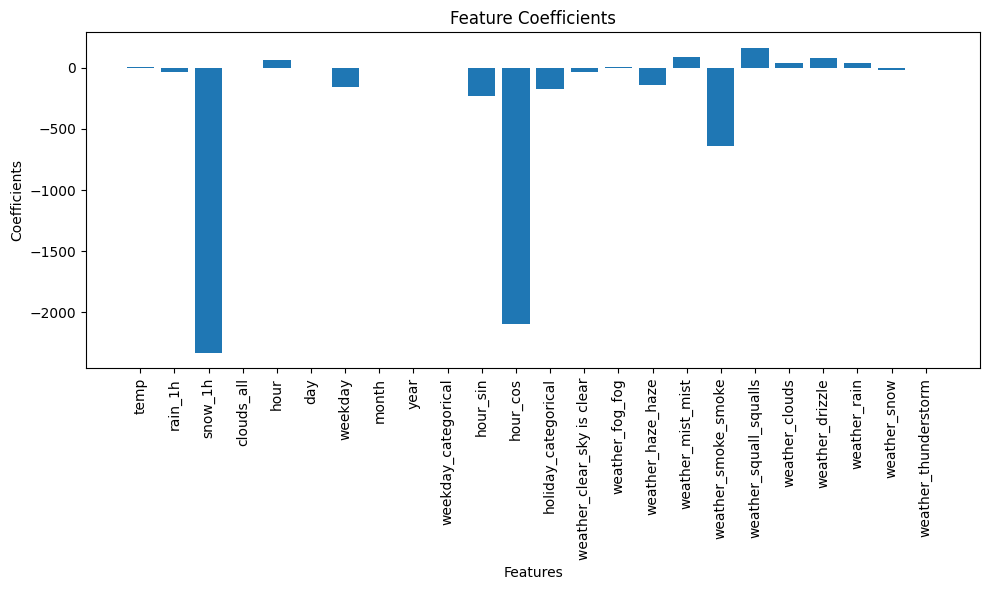

In [55]:
import matplotlib.pyplot as plt

feature_coefficients = LR_model.coef_

# Plot feature coefficients
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_coefficients)), feature_coefficients)
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Feature Coefficients')
plt.xticks(range(len(feature_coefficients)), X_train.columns, rotation=90)
plt.tight_layout()
plt.show()


In [68]:
experiment_tracker_backup=experiment_tracker
experiment_tracker_backup

,experiment_name,test_mse,dummy_mse
0,Exp 1 - Base Model - Linear Regression,1.182175e+06,1.359909e+06
1,Exp 2 - Bayesian Ridge Linear Regression,1.181813e+06,1.358636e+06
2,Exp 3 - Random Forest Regressor with Hyperpara...,1.285480e+05,9.432730e+04
3,Exp 3 - Random Forest Regressor without Hyper ...,1.322952e+05,9.895961e+04
4,Exp 5 - Ridge with best alpha,1.182167e+06,1.359861e+06


In [65]:
# selecting valid features
traffic_data_fs=traffic_data[[*feature_store, target_variable]]

In [95]:

traffic_data_fs=traffic_data_fs.replace(np.nan, 0)
traffic_data_fs.describe()

,temp,rain_1h,snow_1h,clouds_all,hour,day,weekday,month,year,weekday_categorical,...,weather_haze_haze,weather_mist_mist,weather_smoke_smoke,weather_squall_squalls,weather_clouds,weather_drizzle,weather_rain,weather_snow,weather_thunderstorm,traffic_volume
count,27442.000000,27442.000000,27442.000000,27442.000000,27442.000000,27442.000000,27442.000000,27442.000000,27442.000000,27442.0,...,27442.000000,27442.000000,27442.000000,27442.000000,27442.000000,27442.000000,27442.000000,27442.000000,27442.000000,27442.000000
mean,281.245336,0.089718,0.000117,45.632315,11.501385,15.656038,2.998980,6.462503,2015.490015,1.0,...,0.023067,0.096312,0.000255,0.000036,1.056264,0.063151,0.309270,0.225129,0.033379,3278.861781
std,13.704942,0.873248,0.005532,38.468733,6.958917,8.758668,2.002112,3.385219,1.891366,0.0,...,0.150119,0.295024,0.015970,0.006037,1.546329,0.415067,1.042206,1.023202,0.389610,1986.869363
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2012.000000,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,271.870000,0.000000,0.000000,1.000000,5.000000,8.000000,1.000000,4.000000,2014.000000,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1233.000000
50%,282.764000,0.000000,0.000000,40.000000,11.000000,16.000000,3.000000,7.000000,2016.000000,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3400.000000
75%,292.150000,0.000000,0.000000,90.000000,18.000000,23.000000,5.000000,9.000000,2017.000000,1.0,...,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,4942.750000
max,308.430000,55.630000,0.510000,100.000000,23.000000,31.000000,6.000000,12.000000,2018.000000,1.0,...,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,7.000000,7.000000,9.000000,7280.000000


In [75]:
##############################
## Step 4: Model Developement
##############################

## below variable will store performance of all the feature selection methods
experiment_tracker=pd.DataFrame(columns=['experiment_name','excluded_features','selected_features', 'r2_score', 'mse'])

def linear_regression_traffic_volume(experiment_name,data_for_model): # Model training,prediction and evalution

    ## 4.0: Extracting which features are getting used
    global traffic_data_fs,target_variable

    original_features= list(traffic_data_fs.columns)
    original_features.remove(target_variable)

    experiment_features=list(data_for_model.columns)
    experiment_features.remove(target_variable)

    # to compare feature list and identify excluded variables
    excluded_features=[]
    for i in range(len(original_features)):
        if original_features[i] not in experiment_features:
            excluded_features.append(original_features[i])

    ## 4.1: Spliting data into train and test
    X_train, X_test, y_train, y_test = train_test_split(data_for_model.loc[:, data_for_model.columns != target_variable], data_for_model[target_variable], random_state=42)

    ## 4.2: Training the model
    LR_model = LinearRegression()
    LR_model.fit(X_train, y_train)

    ## 4.3: Predicting for test
    y_pred=LR_model.predict(X_test)

    ## 4.4: Evaluating Model - R2
    r2_score = LR_model.score(X_train, y_train)

    ## 4.5: Evaluating Model - MSE
    mse = mean_squared_error(y_test, y_pred)

    ## 4.6: Adding data to experiment tracker
    if excluded_features == [] : excluded_features=None
    if experiment_features == [] : experiment_features=None
    experiment_results=pd.DataFrame({'experiment_name':[experiment_name],
                                   'excluded_features':[excluded_features],
                                   'selected_features':[experiment_features],
                                               'r2_score':[r2_score],
                                               'mse':[mse]})

    ## 4.7: Printing result of experiment
    print("Experiment Name: ",experiment_name)
    print("Excluded features: ",excluded_features)
    print("Selected features: ",experiment_features)
    print("R-square of Linear Regression on training set: {:.3f}".format(r2_score))
    print("MSE of Linear Regression on test set: {:.3f}".format(mse))

    return experiment_results


In [76]:
##############################
## Step 5 : Base Model Run - with all feature
##############################
experiment_tracker=linear_regression_traffic_volume("Base Model Run - with all feature",traffic_data_fs)

Experiment Name:  Base Model Run - with all feature
Excluded features:  None
Selected features:  ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'hour', 'day', 'weekday', 'month', 'year', 'weekday_categorical', 'hour_sin', 'hour_cos', 'holiday_categorical', 'weather_clear_sky is clear', 'weather_fog_fog', 'weather_haze_haze', 'weather_mist_mist', 'weather_smoke_smoke', 'weather_squall_squalls', 'weather_clouds', 'weather_drizzle', 'weather_rain', 'weather_snow', 'weather_thunderstorm']
R-square of Linear Regression on training set: 0.696
MSE of Linear Regression on test set: 1201382.646


In [83]:
##############################
## Step 6: Exp 1 - Variance Threshold of 70%
##############################
from sklearn.feature_selection import VarianceThreshold
selector=VarianceThreshold(threshold=(0.7)) # threshold set to 70%
selector.set_output(transform="pandas") # output should be in pandas dataframe
traffic_data_fs_exp=selector.fit_transform(traffic_data_fs.loc[:, traffic_data_fs.columns != target_variable]) # Except target column all the columns are passed
traffic_data_fs_exp = traffic_data_fs_exp.join(traffic_data_fs[[target_variable]], how='outer') # appended target variable
exp_result=linear_regression_traffic_volume("Exp 1 - Variance Threshold of 70%",traffic_data_fs_exp) # conducting experiment
experiment_tracker=pd.concat([experiment_tracker,exp_result])

Experiment Name:  Exp 1 - Variance Threshold of 70%
Excluded features:  ['snow_1h', 'weekday_categorical', 'hour_sin', 'hour_cos', 'holiday_categorical', 'weather_clear_sky is clear', 'weather_fog_fog', 'weather_haze_haze', 'weather_mist_mist', 'weather_smoke_smoke', 'weather_squall_squalls', 'weather_drizzle', 'weather_thunderstorm']
Selected features:  ['temp', 'rain_1h', 'clouds_all', 'hour', 'day', 'weekday', 'month', 'year', 'weather_clouds', 'weather_rain', 'weather_snow']
R-square of Linear Regression on training set: 0.161
MSE of Linear Regression on test set: 3277444.224


In [86]:
##############################
## Step 7: Exp 2 - SelectKBest with mutual info : top 4 features
##############################
from sklearn.feature_selection import mutual_info_regression, SelectKBest
selector=SelectKBest(mutual_info_regression, k=4) # select top 4 features
selector.set_output(transform="pandas") # output should be in pandas dataframe
traffic_data_fs_exp=selector.fit_transform(traffic_data_fs.loc[:, traffic_data_fs.columns != target_variable], traffic_data_fs[target_variable])
traffic_data_fs_exp = traffic_data_fs_exp.join(traffic_data_fs[[target_variable]], how='outer') # appended target variable
exp_result=linear_regression_traffic_volume("Exp 2 - SelectKBest with mutual info : top 4 features",traffic_data_fs_exp) # conducting experiment
experiment_tracker=pd.concat([experiment_tracker,exp_result])



##############################
## Step 8: Exp 3 - SelectKBest with pearson correlation : top 4 features
##############################
from sklearn.feature_selection import r_regression, SelectKBest
selector=SelectKBest(r_regression, k=4) # select top 4 features
selector.set_output(transform="pandas") # output should be in pandas dataframe
traffic_data_fs_exp=selector.fit_transform(traffic_data_fs.loc[:, traffic_data_fs.columns != target_variable], traffic_data_fs[target_variable])
traffic_data_fs_exp = traffic_data_fs_exp.join(traffic_data_fs[[target_variable]], how='outer') # appended target variable
exp_result=linear_regression_traffic_volume("Exp 3 - SelectKBest with pearson correlation : top 4 features",traffic_data_fs_exp) # conducting experiment
experiment_tracker=pd.concat([experiment_tracker,exp_result])



##############################
## Step 9: Exp 4 - SelectKBest with F statistics : top 4 features
##############################
from sklearn.feature_selection import f_regression, SelectKBest
selector=SelectKBest(f_regression, k=4) # select top 4 features
selector.set_output(transform="pandas") # output should be in pandas dataframe
traffic_data_fs_exp=selector.fit_transform(traffic_data_fs.loc[:, traffic_data_fs.columns != target_variable], traffic_data_fs[target_variable])
traffic_data_fs_exp = traffic_data_fs_exp.join(traffic_data_fs[[target_variable]], how='outer') # appended target variable
exp_result=linear_regression_traffic_volume("Exp 4 - SelectKBest with F statistics : top 4 features",traffic_data_fs_exp) # conducting experiment
experiment_tracker=pd.concat([experiment_tracker,exp_result])


##############################
## Step 10: Exp 5 - SelectPercentile with mutual info : top 50 percentile
##############################
from sklearn.feature_selection import mutual_info_regression, SelectPercentile
selector=SelectPercentile(mutual_info_regression, percentile=50) # top 50 percentile
selector.set_output(transform="pandas") # output should be in pandas dataframe
traffic_data_fs_exp=selector.fit_transform(traffic_data_fs.loc[:, traffic_data_fs.columns != target_variable], traffic_data_fs[target_variable])
traffic_data_fs_exp = traffic_data_fs_exp.join(traffic_data_fs[[target_variable]], how='outer') # appended target variable
exp_result=linear_regression_traffic_volume("Exp 5 - SelectPercentile with mutual info : top 50 percentile",traffic_data_fs_exp) # conducting experiment
experiment_tracker=pd.concat([experiment_tracker,exp_result])



##############################
## Step 11: Exp 6 - SelectPercentile with pearson correlation : top 50 percentile
##############################
from sklearn.feature_selection import r_regression, SelectPercentile
selector=SelectPercentile(r_regression, percentile=50) # top 50 percentile
selector.set_output(transform="pandas") # output should be in pandas dataframe
traffic_data_fs_exp=selector.fit_transform(traffic_data_fs.loc[:, traffic_data_fs.columns != target_variable], traffic_data_fs[target_variable])
traffic_data_fs_exp = traffic_data_fs_exp.join(traffic_data_fs[[target_variable]], how='outer') # appended target variable
exp_result=linear_regression_traffic_volume("Exp 6 - SelectPercentile with pearson correlation : top 50 percentile",traffic_data_fs_exp) # conducting experiment
experiment_tracker=pd.concat([experiment_tracker,exp_result])



##############################
## Step 13: Exp 8 - RFE - Lasso - 4 features
##############################
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso

estimator = Lasso()
selector = RFE(estimator, n_features_to_select=4, step=1) # RFE
selector.set_output(transform="pandas") # output should be in pandas dataframe
traffic_data_fs_exp=selector.fit_transform(traffic_data_fs.loc[:, traffic_data_fs.columns != target_variable], traffic_data_fs[target_variable])
traffic_data_fs_exp = traffic_data_fs_exp.join(traffic_data_fs[[target_variable]], how='outer') # appended target variable
exp_result=linear_regression_traffic_volume("Exp 8 - RFE - Lasso - 4 features",traffic_data_fs_exp) # conducting experiment
experiment_tracker=pd.concat([experiment_tracker,exp_result])



##############################
## Step 14: Exp 9 - Select from Model - Lasso on regression
##############################
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso

estimator = Lasso()
estimator.fit(traffic_data_fs.loc[:, traffic_data_fs.columns != target_variable], traffic_data_fs[target_variable])
selector = SelectFromModel(estimator, threshold='mean') # Select from model
selector.set_output(transform="pandas") # output should be in pandas dataframe
traffic_data_fs_exp=selector.fit_transform(traffic_data_fs.loc[:, traffic_data_fs.columns != target_variable], traffic_data_fs[target_variable])
traffic_data_fs_exp = traffic_data_fs_exp.join(traffic_data_fs[[target_variable]], how='outer') # appended target variable
exp_result=linear_regression_traffic_volume("Exp 9 - Select from Model - Lasso on regression",traffic_data_fs_exp) # conducting experiment
experiment_tracker=pd.concat([experiment_tracker,exp_result])


##############################
## Step 15: Exp 10 - Sequential Feature selection - Forward
##############################
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Lasso

estimator = Lasso()
estimator.fit(traffic_data_fs.loc[:, traffic_data_fs.columns != target_variable], traffic_data_fs[target_variable])
selector = SequentialFeatureSelector(estimator, n_features_to_select="auto", direction="forward") # sequence feature selector - forward
selector.set_output(transform="pandas") # output should be in pandas dataframe
traffic_data_fs_exp=selector.fit_transform(traffic_data_fs.loc[:, traffic_data_fs.columns != target_variable], traffic_data_fs[target_variable])
traffic_data_fs_exp = traffic_data_fs_exp.join(traffic_data_fs[[target_variable]], how='outer') # appended target variable
exp_result=linear_regression_traffic_volume("Exp 10 - Sequential Feature selection - Forward",traffic_data_fs_exp) # conducting experiment
experiment_tracker=pd.concat([experiment_tracker,exp_result])


##############################
## Step 16: Exp 11 - Sequential Feature selection - Backward
##############################
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Lasso

estimator = Lasso()
estimator.fit(traffic_data_fs.loc[:, traffic_data_fs.columns != target_variable], traffic_data_fs[target_variable])
selector = SequentialFeatureSelector(estimator, n_features_to_select="auto", direction="backward") # sequence feature selector - backward
selector.set_output(transform="pandas") # output should be in pandas dataframe
traffic_data_fs_exp=selector.fit_transform(traffic_data_fs.loc[:, traffic_data_fs.columns != target_variable], traffic_data_fs[target_variable])
traffic_data_fs_exp = traffic_data_fs_exp.join(traffic_data_fs[[target_variable]], how='outer') # appended target variable
exp_result=linear_regression_traffic_volume("Exp 11 - Sequential Feature selection - Backward",traffic_data_fs_exp) # conducting experiment
experiment_tracker=pd.concat([experiment_tracker,exp_result])


Experiment Name:  Exp 2 - SelectKBest with mutual info : top 4 features
Excluded features:  ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'day', 'month', 'year', 'weekday_categorical', 'holiday_categorical', 'weather_clear_sky is clear', 'weather_fog_fog', 'weather_haze_haze', 'weather_mist_mist', 'weather_smoke_smoke', 'weather_squall_squalls', 'weather_clouds', 'weather_drizzle', 'weather_rain', 'weather_snow', 'weather_thunderstorm']
Selected features:  ['hour', 'weekday', 'hour_sin', 'hour_cos']
R-square of Linear Regression on training set: 0.688
MSE of Linear Regression on test set: 1229591.443
Experiment Name:  Exp 3 - SelectKBest with pearson correlation : top 4 features
Excluded features:  ['rain_1h', 'snow_1h', 'clouds_all', 'day', 'weekday', 'month', 'year', 'hour_sin', 'hour_cos', 'holiday_categorical', 'weather_clear_sky is clear', 'weather_fog_fog', 'weather_haze_haze', 'weather_mist_mist', 'weather_smoke_smoke', 'weather_squall_squalls', 'weather_drizzle', 'weather_rain',

ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [101]:
##############################
## Step 18: Exp 13 - PCA - 4 Components
##############################
from sklearn.decomposition import PCA

traffic_data_fs_exp = PCA(n_components=4, svd_solver='full').fit_transform(traffic_data_fs.loc[:, traffic_data_fs.columns != target_variable])
traffic_data_fs_exp = pd.DataFrame(traffic_data_fs_exp)
traffic_data_fs_exp = traffic_data_fs_exp.join(traffic_data_fs[[target_variable]], how='outer') # appended target variable
traffic_data_fs_exp=traffic_data_fs_exp.fillna(0)
exp_result=linear_regression_traffic_volume("Exp 13 - PCA - 4 Components",traffic_data_fs_exp) # conducting experiment
experiment_tracker=pd.concat([experiment_tracker,exp_result])

Experiment Name:  Exp 13 - PCA - 4 Components
Excluded features:  ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'hour', 'day', 'weekday', 'month', 'year', 'weekday_categorical', 'hour_sin', 'hour_cos', 'holiday_categorical', 'weather_clear_sky is clear', 'weather_fog_fog', 'weather_haze_haze', 'weather_mist_mist', 'weather_smoke_smoke', 'weather_squall_squalls', 'weather_clouds', 'weather_drizzle', 'weather_rain', 'weather_snow', 'weather_thunderstorm']
Selected features:  [0, 1, 2, 3]
R-square of Linear Regression on training set: 0.001
MSE of Linear Regression on test set: 4518354.377


In [102]:
# traffic_data_fs.info()
traffic_data_fs_exp.isna().any()

0                 False
1                 False
2                 False
3                 False
traffic_volume    False
dtype: bool

In [103]:
experiment_tracker

,experiment_name,excluded_features,selected_features,r2_score,mse
0,Base Model Run - with all feature,None,"[temp, rain_1h, snow_1h, clouds_all, hour, day...",0.696146,1.201383e+06
0,Exp 1 - Variance Threshold of 70%,"[snow_1h, weekday_categorical, hour_sin, hour_...","[temp, rain_1h, clouds_all, hour, day, weekday...",0.160559,3.277444e+06
0,Exp 2 - SelectKBest with mutual info : top 4 f...,"[temp, rain_1h, snow_1h, clouds_all, day, mont...","[hour, weekday, hour_sin, hour_cos]",0.687763,1.229591e+06
0,Exp 3 - SelectKBest with pearson correlation :...,"[rain_1h, snow_1h, clouds_all, day, weekday, m...","[temp, hour, weekday_categorical, weather_clouds]",0.138169,3.377015e+06
0,Exp 4 - SelectKBest with F statistics : top 4 ...,"[temp, rain_1h, snow_1h, clouds_all, day, mont...","[hour, weekday, hour_sin, hour_cos]",0.687763,1.229591e+06
0,Exp 5 - SelectPercentile with mutual info : to...,"[rain_1h, snow_1h, day, weekday_categorical, w...","[temp, clouds_all, hour, weekday, month, year,...",0.695299,1.202801e+06
0,Exp 6 - SelectPercentile with pearson correlat...,"[rain_1h, weekday, month, hour_sin, hour_cos, ...","[temp, snow_1h, clouds_all, hour, day, year, w...",0.139592,3.364123e+06
0,Exp 8 - RFE - Lasso - 4 features,"[temp, rain_1h, snow_1h, clouds_all, hour, day...","[hour_sin, hour_cos, holiday_categorical, weat...",0.652386,1.354067e+06
0,Exp 9 - Select from Model - Lasso on regression,"[temp, rain_1h, snow_1h, clouds_all, hour, day...","[weekday, hour_sin, hour_cos, holiday_categori...",0.675579,1.277181e+06
0,Exp 10 - Sequential Feature selection - Forward,"[snow_1h, day, month, year, weekday_categorica...","[temp, rain_1h, clouds_all, hour, weekday, hou...",0.695600,1.201066e+06


In [107]:
import xgboost as xgb

# Create an XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

exp_result=evaluate_model("Exp 7 - XGBoost",
                                    xgb_model,
                                    X_test, y_test) # conducting experiment

# tracking experiment
experiment_tracker_backup= pd.concat([experiment_tracker, exp_result], ignore_index=True)
experiment_tracker_backup

,experiment_name,excluded_features,selected_features,r2_score,mse,test_mse,dummy_mse
0,Base Model Run - with all feature,None,"[temp, rain_1h, snow_1h, clouds_all, hour, day...",0.696146,1.201383e+06,NaN,NaN
1,Exp 1 - Variance Threshold of 70%,"[snow_1h, weekday_categorical, hour_sin, hour_...","[temp, rain_1h, clouds_all, hour, day, weekday...",0.160559,3.277444e+06,NaN,NaN
2,Exp 2 - SelectKBest with mutual info : top 4 f...,"[temp, rain_1h, snow_1h, clouds_all, day, mont...","[hour, weekday, hour_sin, hour_cos]",0.687763,1.229591e+06,NaN,NaN
3,Exp 3 - SelectKBest with pearson correlation :...,"[rain_1h, snow_1h, clouds_all, day, weekday, m...","[temp, hour, weekday_categorical, weather_clouds]",0.138169,3.377015e+06,NaN,NaN
4,Exp 4 - SelectKBest with F statistics : top 4 ...,"[temp, rain_1h, snow_1h, clouds_all, day, mont...","[hour, weekday, hour_sin, hour_cos]",0.687763,1.229591e+06,NaN,NaN
5,Exp 5 - SelectPercentile with mutual info : to...,"[rain_1h, snow_1h, day, weekday_categorical, w...","[temp, clouds_all, hour, weekday, month, year,...",0.695299,1.202801e+06,NaN,NaN
6,Exp 6 - SelectPercentile with pearson correlat...,"[rain_1h, weekday, month, hour_sin, hour_cos, ...","[temp, snow_1h, clouds_all, hour, day, year, w...",0.139592,3.364123e+06,NaN,NaN
7,Exp 8 - RFE - Lasso - 4 features,"[temp, rain_1h, snow_1h, clouds_all, hour, day...","[hour_sin, hour_cos, holiday_categorical, weat...",0.652386,1.354067e+06,NaN,NaN
8,Exp 9 - Select from Model - Lasso on regression,"[temp, rain_1h, snow_1h, clouds_all, hour, day...","[weekday, hour_sin, hour_cos, holiday_categori...",0.675579,1.277181e+06,NaN,NaN
9,Exp 10 - Sequential Feature selection - Forward,"[snow_1h, day, month, year, weekday_categorica...","[temp, rain_1h, clouds_all, hour, weekday, hou...",0.695600,1.201066e+06,NaN,NaN


In [108]:
xgb_prediction=xgb_model.predict(test_data[feature_store])

# Save results to CSV
submission = pd.DataFrame({'ID': test_data.index, 'traffic_volume' : xgb_prediction})
submission.to_csv('Exp7_XGBoost.csv', index=False)

In [109]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

# Assuming X_train and y_train are your training features and target, respectively

# Create an XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001]
}

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and corresponding model
best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}


In [110]:
exp_result=evaluate_model("Exp 7 - XGBoost with hyperparameter tuning",
                                    best_xgb_model,
                                    X_test, y_test) # conducting experiment

# tracking experiment
experiment_tracker_backup= pd.concat([experiment_tracker_backup, exp_result], ignore_index=True)
experiment_tracker_backup

,experiment_name,excluded_features,selected_features,r2_score,mse,test_mse,dummy_mse
0,Base Model Run - with all feature,None,"[temp, rain_1h, snow_1h, clouds_all, hour, day...",0.696146,1.201383e+06,NaN,NaN
1,Exp 1 - Variance Threshold of 70%,"[snow_1h, weekday_categorical, hour_sin, hour_...","[temp, rain_1h, clouds_all, hour, day, weekday...",0.160559,3.277444e+06,NaN,NaN
2,Exp 2 - SelectKBest with mutual info : top 4 f...,"[temp, rain_1h, snow_1h, clouds_all, day, mont...","[hour, weekday, hour_sin, hour_cos]",0.687763,1.229591e+06,NaN,NaN
3,Exp 3 - SelectKBest with pearson correlation :...,"[rain_1h, snow_1h, clouds_all, day, weekday, m...","[temp, hour, weekday_categorical, weather_clouds]",0.138169,3.377015e+06,NaN,NaN
4,Exp 4 - SelectKBest with F statistics : top 4 ...,"[temp, rain_1h, snow_1h, clouds_all, day, mont...","[hour, weekday, hour_sin, hour_cos]",0.687763,1.229591e+06,NaN,NaN
5,Exp 5 - SelectPercentile with mutual info : to...,"[rain_1h, snow_1h, day, weekday_categorical, w...","[temp, clouds_all, hour, weekday, month, year,...",0.695299,1.202801e+06,NaN,NaN
6,Exp 6 - SelectPercentile with pearson correlat...,"[rain_1h, weekday, month, hour_sin, hour_cos, ...","[temp, snow_1h, clouds_all, hour, day, year, w...",0.139592,3.364123e+06,NaN,NaN
7,Exp 8 - RFE - Lasso - 4 features,"[temp, rain_1h, snow_1h, clouds_all, hour, day...","[hour_sin, hour_cos, holiday_categorical, weat...",0.652386,1.354067e+06,NaN,NaN
8,Exp 9 - Select from Model - Lasso on regression,"[temp, rain_1h, snow_1h, clouds_all, hour, day...","[weekday, hour_sin, hour_cos, holiday_categori...",0.675579,1.277181e+06,NaN,NaN
9,Exp 10 - Sequential Feature selection - Forward,"[snow_1h, day, month, year, weekday_categorica...","[temp, rain_1h, clouds_all, hour, weekday, hou...",0.695600,1.201066e+06,NaN,NaN


In [111]:
xgb_prediction=best_xgb_model.predict(test_data[feature_store])

# Save results to CSV
submission = pd.DataFrame({'ID': test_data.index, 'traffic_volume' : xgb_prediction})
submission.to_csv('Exp7_XGBoost_hyper_parameter_tuning.csv', index=False)

### 2. Baysian Ridge

In [49]:
from sklearn.linear_model import BayesianRidge

# Training Model
BR_model = BayesianRidge()
BR_model.fit(X_train, y_train)

# R2 Score Model
r2_score = BR_model.score(X_train, y_train)
print("R2 Score: ",r2_score)

# evaluating model
exp_result=evaluate_model("Exp 2 - Bayesian Ridge Linear Regression",
                                    BR_model,
                                    X_test, y_test) # conducting experiment

# tracking experiment
experiment_tracker= pd.concat([experiment_tracker, exp_result], ignore_index=True)
experiment_tracker

R2 Score:  0.6953280817662266


,experiment_name,test_mse,dummy_mse
0,Exp 1 - Base Model - Linear Regression,1.182175e+06,1.359909e+06
1,Exp 2 - Bayesian Ridge Linear Regression,1.181813e+06,1.358636e+06


In [50]:
BR_prediction=BR_model.predict(test_data[feature_store])

# Save results to CSV
submission = pd.DataFrame({'ID': test_data.index, 'traffic_volume' : BR_prediction})
submission.to_csv('Exp2_Bayesian_Ridge_prediction.csv', index=False)

### 3. RandomForest Regressor

In [51]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Hyper parameter
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20],       # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required at each leaf node
}

# Initiating model
random_forest_model = RandomForestRegressor(random_state=42)

# Perform GridSearchCV to find the best combination of hyperparameters
grid_search = GridSearchCV(estimator=random_forest_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model and make predictions on the testing data
best_random_forest_model = grid_search.best_estimator_

# evaluating model
exp_result=evaluate_model("Exp 3 - Random Forest Regressor with Hyperparameter tuning",
                                    best_random_forest_model,
                                    X_test, y_test) # conducting experiment

# tracking experiment
experiment_tracker= pd.concat([experiment_tracker, exp_result], ignore_index=True)
experiment_tracker

,experiment_name,test_mse,dummy_mse
0,Exp 1 - Base Model - Linear Regression,1.182175e+06,1.359909e+06
1,Exp 2 - Bayesian Ridge Linear Regression,1.181813e+06,1.358636e+06
2,Exp 3 - Random Forest Regressor with Hyperpara...,1.285480e+05,9.432730e+04


In [52]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Initiating model
random_forest_model_v2 =  RandomForestRegressor(n_estimators=100, random_state=42)
random_forest_model_v2.fit(X_train, y_train)


# evaluating model
exp_result=evaluate_model("Exp 4 - Random Forest Regressor without Hyper Parameter Tuning",
                                    random_forest_model_v2,
                                    X_test, y_test) # conducting experiment

# tracking experiment
experiment_tracker= pd.concat([experiment_tracker, exp_result], ignore_index=True)
experiment_tracker

,experiment_name,test_mse,dummy_mse
0,Exp 1 - Base Model - Linear Regression,1.182175e+06,1.359909e+06
1,Exp 2 - Bayesian Ridge Linear Regression,1.181813e+06,1.358636e+06
2,Exp 3 - Random Forest Regressor with Hyperpara...,1.285480e+05,9.432730e+04
3,Exp 3 - Random Forest Regressor without Hyper ...,1.322952e+05,9.895961e+04


### 4. Simple Ridge

In [53]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Assuming X_train and y_train are your training features and target, respectively

# Define the parameter grid for alpha (regularization strength)
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}  # Adjust the range as needed

# Create Ridge regression model
ridge_model = Ridge()

# Perform GridSearchCV for parameter selection
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best alpha and corresponding model
best_alpha = grid_search.best_params_['alpha']
best_model = grid_search.best_estimator_

# Optionally, you can also print the best alpha and best model
print("Best alpha:", best_alpha)
print("Best model:", best_model)

Best alpha: 0.01
Best model: Ridge(alpha=0.01)


In [54]:
# evaluating model
exp_result=evaluate_model("Exp 5 - Ridge with best alpha",
                                    best_model,
                                    X_test, y_test) # conducting experiment

# tracking experiment
experiment_tracker= pd.concat([experiment_tracker, exp_result], ignore_index=True)
experiment_tracker

,experiment_name,test_mse,dummy_mse
0,Exp 1 - Base Model - Linear Regression,1.182175e+06,1.359909e+06
1,Exp 2 - Bayesian Ridge Linear Regression,1.181813e+06,1.358636e+06
2,Exp 3 - Random Forest Regressor with Hyperpara...,1.285480e+05,9.432730e+04
3,Exp 3 - Random Forest Regressor without Hyper ...,1.322952e+05,9.895961e+04
4,Exp 5 - Ridge with best alpha,1.182167e+06,1.359861e+06


## Step 9: Evaluation

### Evaluation Step 1: Predicting on test data

## Step 10: Conclusion